In [59]:
import re
from datetime import datetime

In [60]:
import os
import geopandas as gpd
import geemap
import xml.etree.ElementTree as ET
import pandas as pd
from shapely.geometry import LineString

# constante requerida
namespace = {"kml": "http://www.opengis.net/kml/2.2"}

In [61]:
# Directorio donde están los archivos KML
path_kml = r'G:/OneDrive - Ingenio Azucarero Guabira S.A/UTEA_2023/PROYECTO AREA LIBERACION/SEGUIMIENTO2/LOGS_GRAL/'
contenido = os.listdir(path_kml)
len(contenido)

231

In [77]:
def extraer_fecha(fecha_txt):
    match = re.search(r"([A-Za-z]{3}-\d{1,2}[a-z]{2}-\d{4})", fecha_txt)
    return match.group(1) if match else None

def format_date(date_str):
    try:
        # Eliminar sufijos ordinales para facilitar la conversión
        date_without_suffix = re.sub(r'(st|nd|rd|th)', '', date_str)
        return pd.to_datetime(date_without_suffix, format='%b-%d-%Y').strftime('%d/%m/%Y')
    except:
        return None

def week_number(date_str):
    """
    Retorna el número de semana del año para una fecha dada en formato "dd/mm/aaaa".
    """
    try:
        date_obj = pd.to_datetime(date_str, format='%d/%m/%Y')
        return date_obj.isocalendar()[1]  # El segundo valor de isocalendar() es el número de semana
    except:
        return None

In [63]:
# lista para almacenar nombres de archivo
file_name = []
# lista para alamcenar recorridos
lineas = []

# itera sobre la lista de nombres de archivos
for i in contenido:
    # directorio + nombre de archivo
    path = path_kml + i
    # leer el arbol de contenido del archivo
    tree = ET.parse(path)
    root = tree.getroot()
    for placemark in root.findall(".//kml:Placemark", namespace):
        coord_text = placemark.find(".//kml:coordinates", namespace).text.strip()
        # obtiene las cooredenadas
        coords = coord_text.split('\n')
        # lista para guardar las coors
        coordinates = []
        # recorre las coors
        for j in coords:
            # split para separa el 3er elemento que acompaña las coors
            coord = j.split(',')
            # agrega las coors a la lista
            coordinates.append((float(coord[0]), float(coord[1])))
    # conviente en DF
    df = pd.DataFrame(coordinates, columns=['Longitude', 'Latitude'])
    # convierte en GDF
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
    # convierte el GDF en Linea
    line = LineString(gdf.geometry.tolist())
    # se almacena en listas el nombre del archivo y la geomedia del recorrido
    file_name.append(i)
    lineas.append(line)

In [66]:
fechas = [extraer_fecha(i) for i in file_name]

In [68]:
fechas = [format_date(i) for i in fechas]

In [78]:
semanas = [week_number(i) for i in fechas]

In [81]:
# dic con la geometria y el file_name
data_lineas = {
    'geometry': lineas,
    'nombre': file_name,
    'fecha' : fechas,
    'semana' : semanas
}

In [82]:
gdf_lineas = gpd.GeoDataFrame(data_lineas)

In [83]:
gdf_lineas.crs = "EPSG:4326"

In [84]:
gdf_lineas = gdf_lineas.to_crs(epsg=32720)

In [85]:
gdf_lineas

,geometry,nombre,fecha,semana
0,"LINESTRING (483421.207 8102178.225, 483421.210...",Oct-11th-2023-08-51PM-Flight-Airdata.kml,11/10/2023,41
1,"LINESTRING (483422.403 8102178.651, 483422.422...",Oct-11th-2023-08-56PM-Flight-Airdata.kml,11/10/2023,41
2,"LINESTRING (483281.322 8101887.131, 483281.317...",Oct-11th-2023-09-20PM-Flight-Airdata.kml,11/10/2023,41
3,"LINESTRING (483281.357 8101887.026, 483281.353...",Oct-11th-2023-09-22PM-Flight-Airdata.kml,11/10/2023,41
4,"LINESTRING (483149.858 8101177.268, 483149.859...",Oct-11th-2023-09-34PM-Flight-Airdata.kml,11/10/2023,41
...,...,...,...,...
226,"LINESTRING (467747.528 8079687.305, 467747.526...",Sep-9th-2023-07-28PM-Flight-Airdata.kml,09/09/2023,36
227,"LINESTRING (468017.014 8079757.806, 468017.011...",Sep-9th-2023-07-39PM-Flight-Airdata.kml,09/09/2023,36
228,"LINESTRING (467625.403 8080003.384, 467625.405...",Sep-9th-2023-08-03PM-Flight-Airdata.kml,09/09/2023,36
229,"LINESTRING (467619.715 8080025.696, 467619.713...",Sep-9th-2023-08-51PM-Flight-Airdata.kml,09/09/2023,36


<AxesSubplot:>

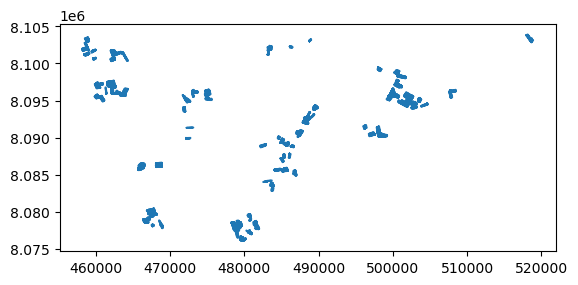

In [86]:
gdf_lineas.plot()

In [87]:
len(gdf_lineas)

231

In [88]:
gdf_lineas.to_file('capa_logs', driver="ESRI Shapefile")